# Logistic Regression
In this experiment, we use simple logistic regression through gradient descent to classify varieties of the Iris dataset.

In [103]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from argparse import ArgumentParser

In order to access the dataset, you may download it from the following [link](https://gist.github.com/netj/8836201) or load it from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

In [104]:
df = pd.read_csv("Datasets/iris.csv")
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


We will implement binary classification for this experiment. However, since the Iris dataset originally has 3 classes (Setosa, Versicolor, and Virginica), we will remove all Virginia data in our dataset. Moreover, we will set the value of Setosa to $0$, while Versicolor is set to $1$.

In [105]:
df = df.drop(range(100,150)) # Remove Virginica from dataset

df.loc[df["variety"] == "Setosa", "variety"] = 0. # Change Setosa to class 0
df.loc[df["variety"] == "Versicolor", "variety"] = 1. # Change Versicolor to class 1
display(df)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


Now, we separate the $x$ (Features), $y$ (Variety), and $m$ (Number of datapoints) values from the pandas dataframe.

In [106]:
x = torch.tensor(df.iloc[0:,:4].values, dtype=torch.float32)
y = torch.tensor(df.iloc[0:,4].values.astype(np.float32), dtype=torch.float32)
m = df.count(axis=0)[0]

In order to further simplify the regression model, we will handpick which feature we will use as our $x$. By displaying the scatter plot between each features as $x$ and the variety as $y$, we have observed that the features 'Petal length' and 'Petal width' may fit best for our logistic regression model.

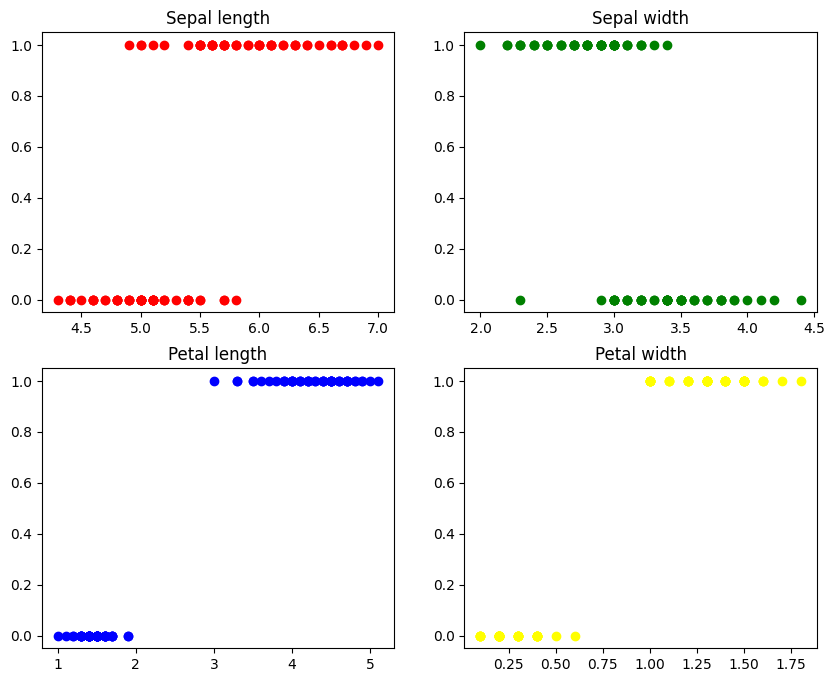

In [107]:
fig = plt.figure(figsize=(10, 8))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.scatter(x[:,0], y, color='red')
plt.title('Sepal length')

fig.add_subplot(rows, columns, 2)
plt.scatter(x[:,1], y, color='green')
plt.title('Sepal width')

fig.add_subplot(rows, columns, 3)
plt.scatter(x[:,2], y, color='blue')
plt.title('Petal length')

fig.add_subplot(rows, columns, 4)
plt.scatter(x[:,3], y, color='yellow')
plt.title('Petal width')

plt.show()

For this experiment, we choose the feature 'Petal length' as our input $x$ and drop the other features in our dataset. We split both $x$ and $y$ into train (90%) and test (10%) sets.

In [108]:
df = df.drop(columns=['sepal.length', 'sepal.width', 'petal.width'])

x = torch.tensor(df.iloc[0:,0].values, dtype=torch.float32)
x_train = torch.cat((x[:45],x[50:95]))
x_test = torch.cat((x[45:50],x[95:]))

y = torch.tensor(df.iloc[0:,1].values.astype(np.float32), dtype=torch.float32)
y_train = torch.cat((y[:45],y[50:95]))
y_test = torch.cat((y[45:50],y[95:]))

m = df.count(axis=0)[0]
display(df)

,petal.length,variety
0,1.4,0.0
1,1.4,0.0
2,1.3,0.0
3,1.5,0.0
4,1.4,0.0
...,...,...
95,4.2,1.0
96,4.2,1.0
97,4.3,1.0
98,3.0,1.0


We now define our logistic regression model. The formulas used for the functions is from [Baeldung on CS](https://www.baeldung.com/cs/gradient-descent-logistic-regression). $z$ returns the linear equation, $h$ returns the $h(x)$ of the logistic regression model, $J$ is used to compute for the cost function, $d0$ and $d1$ are used to compute for the partial derivatives for the gradient descent, while $gd$ updates the weight/slope and bias terms.

In [109]:
class LogRegression():
    def __init__(self, b, w, lr, epochs):
        self.b = b
        self.w = w
        self.wsize = list(self.w.shape)[0]
        self.lr = lr
        self.epochs = epochs

    def z(self, x):
        return self.w*x + self.b if self.wsize == 1 else self.w @ x.T + self.b

    def h(self, x):
        return 1/(1+torch.exp(-self.z(x)))
    
    def J(self, x, y, m):
        return torch.sum((y*torch.log(self.h(x))) + ((1-y)*torch.log(1-self.h(x))))/-m

    def d0(self, x, y, m):
        return torch.sum(self.h(x) - y)/m

    def d1(self, x, y, m, i):
        return torch.sum((self.h(x) - y)*x)/m if self.wsize == 1 else torch.dot(self.h(x) - y, x[:,i])/m 

    def gd(self, x, y, m):
        tempw = torch.zeros(self.wsize, device='cuda')
        tempb = self.b - self.lr*self.d0(x, y, m)
        for i in range(self.wsize):
            tempw[i] = self.w[i] - self.lr*self.d1(x, y, m, i)
        return tempb, tempw
    
    def fit(self, x, y, m):
        print(f'Number of Epochs: {self.epochs}')
        for epoch in range(self.epochs):
            cost = self.J(x, y, m)
            if epoch % (self.epochs//10) == 0 or epoch == (self.epochs-1):
                print(f'Epoch {epoch}:')
                print(f'w = {self.w.item()}', end = ' | ')
                print(f'b = {self.b}', end = ' | ')
                print(f'Cost = {cost:.3f}')
            self.b, self.w = self.gd(x, y, m)

    def predict(self, x):
        return (self.h(x)>0.5).float()
    
    def accuracy(self, x, y, show=False):
        if show == True:
            for i, val in enumerate(x):
                print(f'Prediction: {self.predict(val).item()} | Actual: {y[i]}')
        return (torch.sum((self.predict(x)==y).float())/list(y.shape)[0]) * 100.

    def wb(self):
        return self.b, self.w

We now setup our arguments and train the model. Afterwards, we fetch the weight and bias terms and print them.

In [110]:
def get_args():
    parser = ArgumentParser(description="Logistic Regression")
    parser.add_argument("--epochs", type=int, default=1000, help="num epochs")
    parser.add_argument("--lr", type=float, default=1., help="learning rate")

    args = parser.parse_args("")
    return args

if __name__ == "__main__":
    args = get_args()
    bw = torch.tensor([0.,1.], device='cuda')
    
    # Initialize the logistic regression model
    lr = LogRegression(bw[0], bw[1:], args.lr, args.epochs)
    lr.fit(x_train.to('cuda'),y_train.to('cuda'),m)

    # Return the weight/slope and bias values from the trained model
    b, w = lr.wb()
    print(f'\nWeight/Slope: {w.item()}\nBias: {b}')

Number of Epochs: 1000
Epoch 0:
w = 1.0 | b = 0.0 | Cost = 0.760
Epoch 100:
w = 2.1472244262695312 | b = -5.556910037994385 | Cost = 0.059
Epoch 200:
w = 2.710970163345337 | b = -7.08716344833374 | Cost = 0.032
Epoch 300:
w = 3.0560641288757324 | b = -8.007514953613281 | Cost = 0.022
Epoch 400:
w = 3.306969165802002 | b = -8.670572280883789 | Cost = 0.017
Epoch 500:
w = 3.5049192905426025 | b = -9.19064998626709 | Cost = 0.014
Epoch 600:
w = 3.668787956237793 | b = -9.619422912597656 | Cost = 0.012
Epoch 700:
w = 3.8088204860687256 | b = -9.98470401763916 | Cost = 0.010
Epoch 800:
w = 3.93121600151062 | b = -10.303216934204102 | Cost = 0.009
Epoch 900:
w = 4.04001522064209 | b = -10.58580207824707 | Cost = 0.008
Epoch 999:
w = 4.137072563171387 | b = -10.837494850158691 | Cost = 0.007

Weight/Slope: 4.138006210327148
Bias: -10.839913368225098


To check if our model properly classifies the data, we plot the sigmoid function over the actual data. Upon observation, we see that the model properly estimates our data.

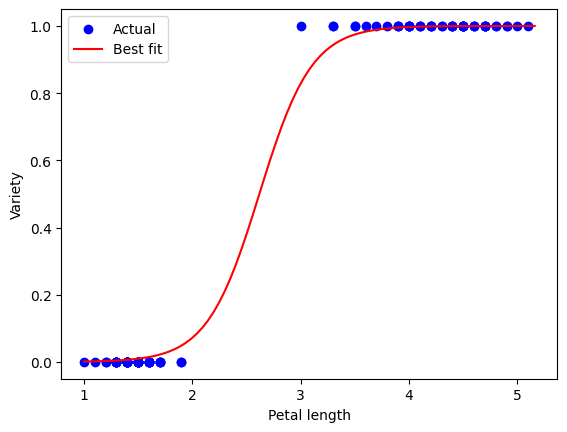

In [111]:
plt.scatter(x, y, label='Actual', color='blue')

x1 = torch.arange(1, 5.2, 0.052)
y1 = lr.h(x1.to('cuda'))
pyplot.plot(x1.to('cpu'), y1.to('cpu'), label='Best fit', color='red')

pyplot.xlabel("Petal length")
pyplot.ylabel("Variety")
pyplot.legend()
pyplot.show()

Moreover, if we check our model through the test data, we achieve $100\%$ accuracy.

In [112]:
acc = lr.accuracy(x_test.to('cuda'), y_test.to('cuda'), show=True)
print(f'Test accuracy: {acc.item()}%')

Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 0.0 | Actual: 0.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Prediction: 1.0 | Actual: 1.0
Test accuracy: 100.0%


As a form of cross-checking, we also feed our data into scikit-learn's LogisticRegression() module. If we print the weight and bias terms, we observe slightly different different values.

In [113]:
lr1 = LogisticRegression()
lr1.fit(x_train.reshape(-1,1),y_train)
print(f'Weight/Slope: {lr1.coef_[0][0]}')
print(f'Bias: {lr1.intercept_[0]}')

Weight/Slope: 2.8095687752044607
Bias: -7.753488397179931


By plotting the sigmoid function with the actual values, we see a slight difference on the plot but it still properly estimates the data. We believe that this might be because a different algorithm is used by scikit-learn to come up with the weight and bias values.

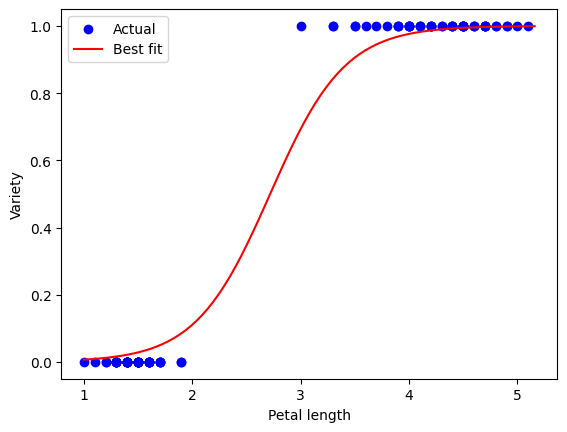

In [114]:
plt.scatter(x, y, label='Actual', color='blue')

y2 = 1/(1+torch.exp(-(2.89999784*x1 + -7.88572444)))
pyplot.plot(x1.to('cpu'), y2.to('cpu'), label='Best fit', color='red')

pyplot.xlabel("Petal length")
pyplot.ylabel("Variety")
pyplot.legend()
pyplot.show()

We see that scikit-learn's LogisticRegression() also achieves $100\%$ accuracy on our test data. We may observe differences between the performance of the two models if we try it on more data, which can reveal certain issues such as overfitting.

In [115]:
y_pred = lr1.predict(x_test.reshape(-1,1))
 
acc1 = accuracy_score(y_test, y_pred)
print(f'Test accuracy {acc1*100}%')

Test accuracy 100.0%
